# Init

In [91]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

def format_measurement_type(measurement_type):
    # Remove trailing underscores, replace remaining underscores with spaces, and title-case the string
    formatted_type = measurement_type.rstrip('_').replace('_', ' ').title()
    return formatted_type

def format_variable_type(variable_type):
    # Remove trailing underscores, replace remaining underscores with spaces, and title-case the string
    formatted_type = variable_type.replace('surface_', '', 1).replace('_', ' ').title()
    return formatted_type

def extract_measurement_type(column_name):
    return re.sub(r"(surface|air)_(100|180|250)_cm", "", column_name)

def create_filename_from_title(folder, title):
    dir_path = os.path.join('temp', 'tsplots', 'ts-all', folder)
    
    # Check if the directory exists, if not, create it
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # Create the filename
    filename = os.path.join(dir_path, re.sub(r'\W+', '', title.replace(' ', '_')).lower() + '.png')
    return filename


# Directory path
directory_path = 'data/sensor_data'

# Define your date range
start_date = '2020-9-1'
end_date = '2023-5-30'

# Convert string dates to matplotlib understandable format
start_date = mdates.datestr2num(start_date)
end_date = mdates.datestr2num(end_date)

#Add default color palette
cols = [sns.color_palette('Paired', 12)[0],
        sns.color_palette('Paired', 12)[4],
        sns.color_palette('Paired', 12)[2]
]

sns.set_context('poster', 
                font_scale= 0.7, 
                rc = {'legend.fontsize': 16,
                      'legend.title_fontsize': 18})
sns.set_style('whitegrid')
sns.set_palette(cols)

# Plot Soil Moisture for All Plots

In [ ]:
# Add sensor color palette 
pp = sns.color_palette('Paired', 12)

p = {
    'Left 30cm': pp[0],   # Light Blue
    'Right 30cm': pp[1],  # Dark Blue
    'Left 60cm': pp[2],   # Light Green
    'Right 60cm': pp[3],  # Dark Green
    'Left 90cm': pp[4],   # Light Red
    'Right 90cm': pp[5]   # Dark Red
}

# Iterate over all CSV files in the directory
for filename in os.listdir(directory_path):
    if filename.startswith("patch") and not filename.endswith("mobil.csv"):
        # Load the data
        data = pd.read_csv(os.path.join(directory_path, filename), sep=',')
        patch = filename.split("_")[1].split(".")[0]

        # Convert the 'datetime' column to a datetime object
        data['datetime'] = pd.to_datetime(data['dateTime'])

        # Set the 'datetime' column as the index
        data.set_index('datetime', inplace=True)

        filtered_columns = [col for col in data.columns if 'water_content' in col]
        filtered_df = data[filtered_columns]

        long_df = pd.melt(filtered_df.reset_index(), id_vars=['datetime'], var_name='side_depth', value_name='wc')
        
        long_df['side_depth'] = (long_df['side_depth']
                                 .str.replace('water_content_', '')
                                 .str.replace('_cm', '')
                                 .str.replace('_', ' ')
                                 .str.title() 
                                 + 'cm')

        # Create a new figure
        plt.figure(figsize=(15, 8))

        sns.lineplot(data=long_df.dropna(), x='datetime', y='wc', hue='side_depth', palette = p)

        # Set the title, x-label, y-label, and legend
        title = f'Time Series of Water Content by Depth for Patch {patch}'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Volumetric Water Content (%)')
        plt.legend(title='Sensor Side and Depth', loc = 'best')
        plt.grid(True)
        plt.xlim(start_date, end_date)
        plt.ylim(0,35)

        # Save the plot
        plt.savefig(create_filename_from_title("wc_all_patches", title),
                    dpi = 300,
                    bbox_inches = 'tight')
        
        # Show the plot
        plt.show()


# Plot All Variables for One Patch

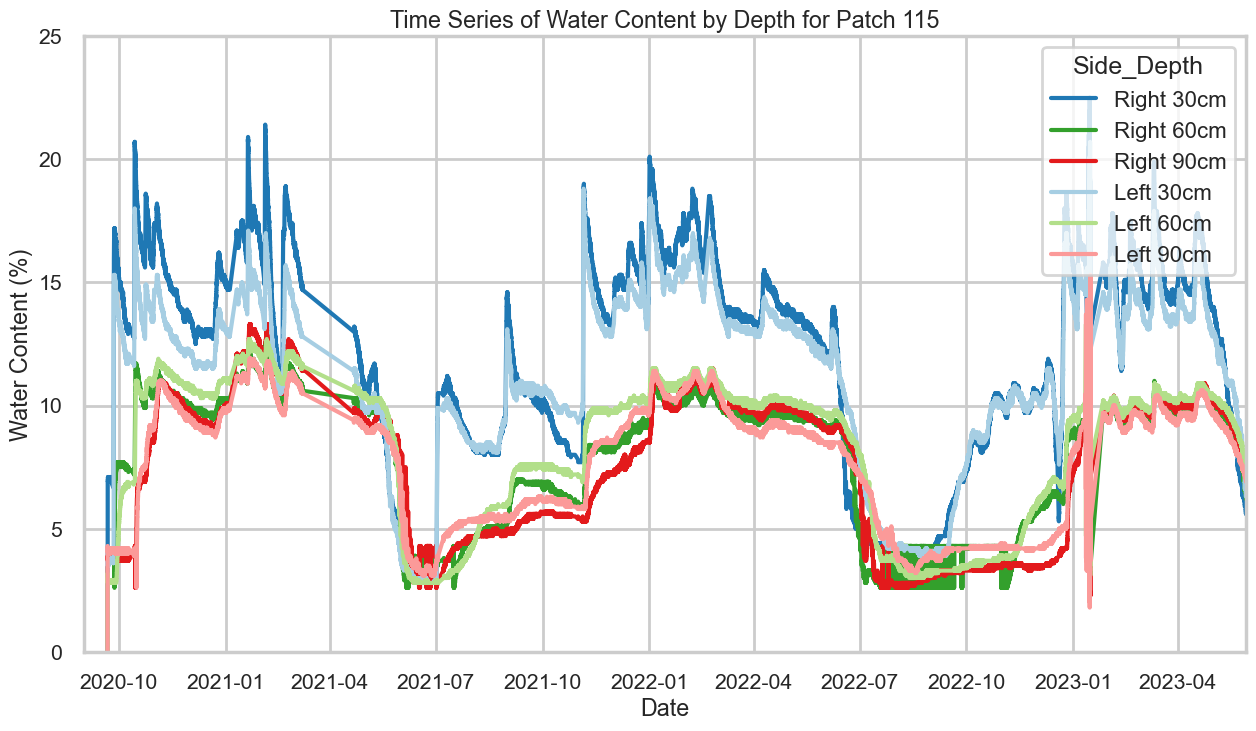

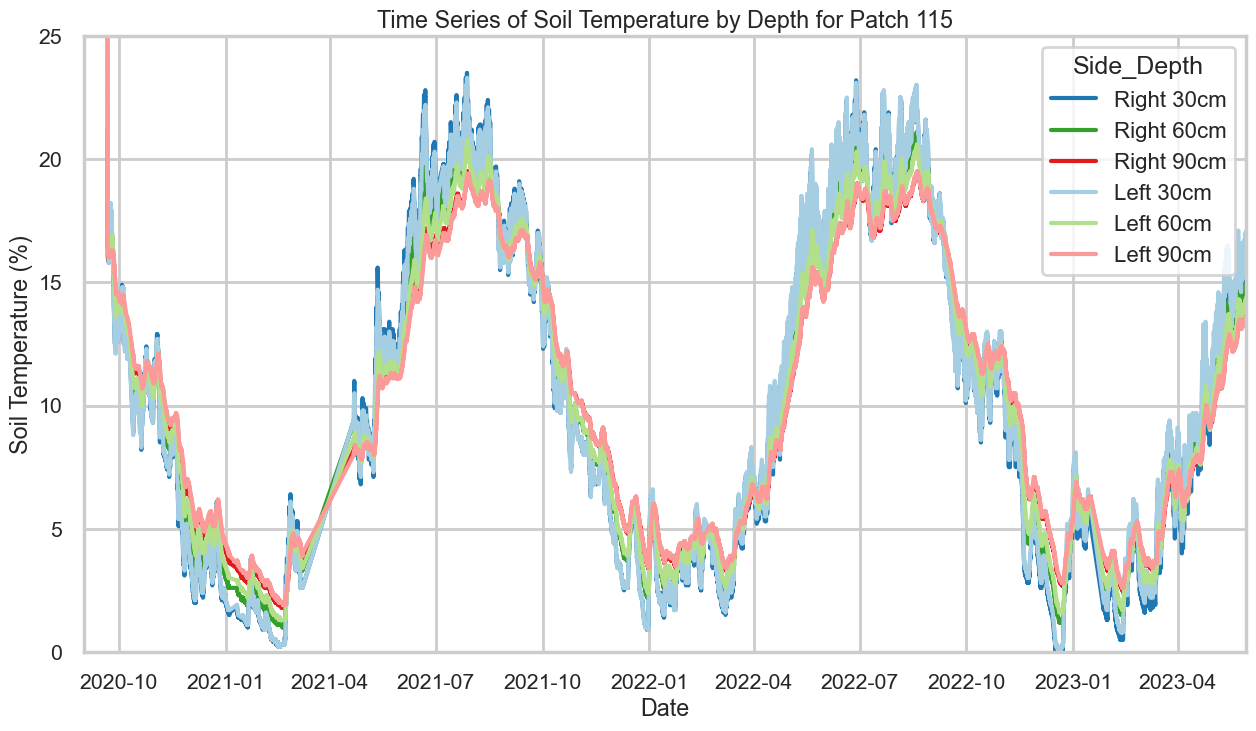

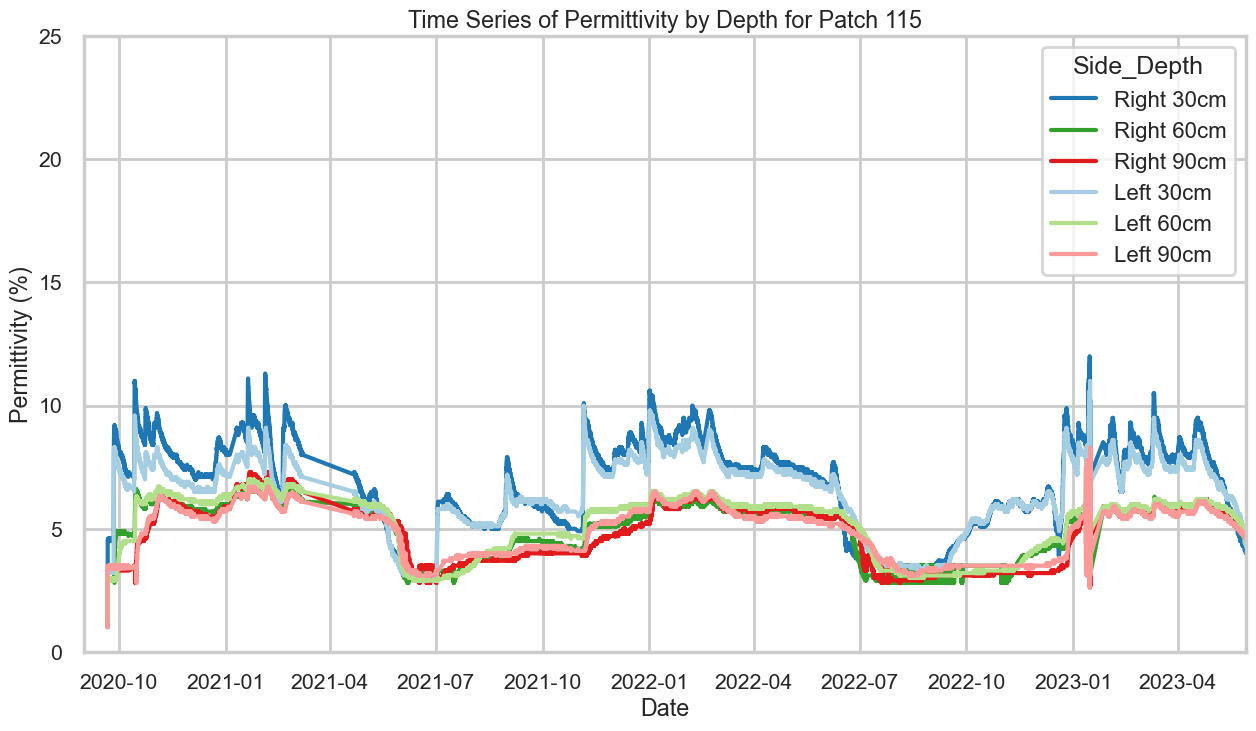

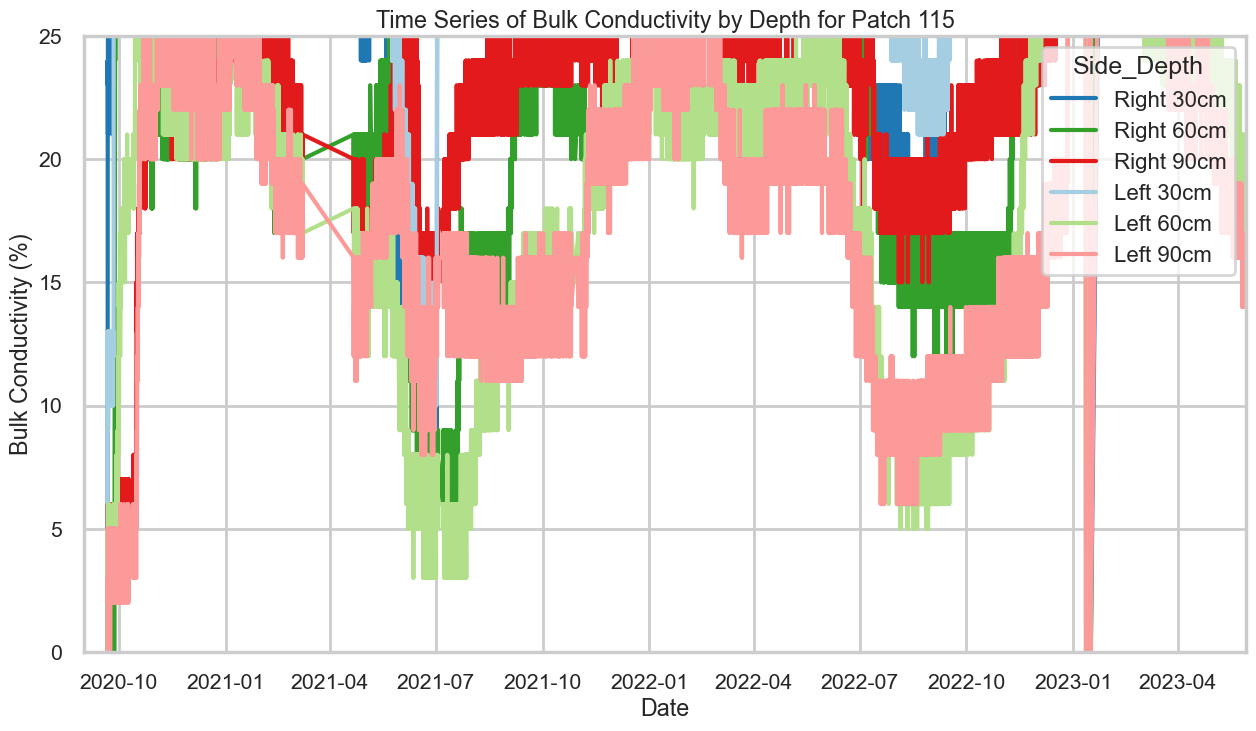

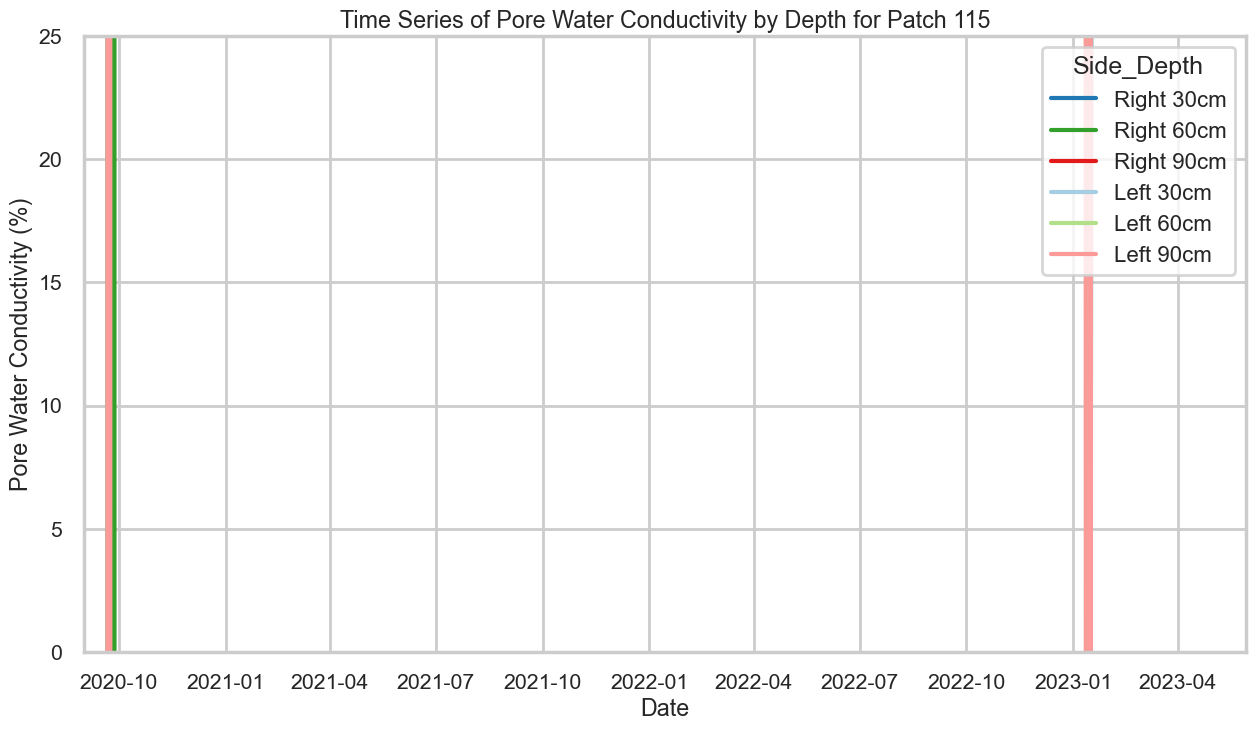

In [96]:
pattern = re.compile(r"(left|right)_(30|60|90)")

##INPUT HERE
desired_patch = "patch_115" #input as string, patch_19, patch_109, etc.
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add sensor color palette 
pp = sns.color_palette('Paired', 12)

p = {
    'Left 30cm': pp[0],   # Light Blue
    'Right 30cm': pp[1],  # Dark Blue
    'Left 60cm': pp[2],   # Light Green
    'Right 60cm': pp[3],  # Dark Green
    'Left 90cm': pp[4],   # Light Red
    'Right 90cm': pp[5]   # Dark Red
}

# Function to extract the measurement type from the column name
def extract_measurement_type(column_name):
    # Replace left/right and depth information to extract the measurement type
    return re.sub(r"(left|right)_(30|60|90)_cm", "", column_name)

# Iterate over all CSV files in the directory
for filename in os.listdir(directory_path):
    if filename.startswith(desired_patch):
        # Load the data
        data = pd.read_csv(os.path.join(directory_path, filename), sep=',')
        patch = filename.split("_")[1].split(".")[0]

        # Convert the 'datetime' column to a datetime object
        data['datetime'] = pd.to_datetime(data['dateTime'])

        # Set the 'datetime' column as the index
        data.set_index('datetime', inplace=True)
        
        # Group columns by their measurement type
        column_groups = {}
        for col in data.columns:
            if pattern.search(col):  # Only consider relevant columns
                measurement_type = extract_measurement_type(col)
                column_groups.setdefault(measurement_type, []).append(col)

        # For each measurement type, plot all relevant columns on a single graph
        for measurement_type, cols in column_groups.items():
            # Melt data into long format
            long_df = data[cols].reset_index().melt(id_vars=['datetime'], var_name='side_depth', value_name='value')
            
            # Extract and shorten the side_depth column using regex
            long_df['side_depth'] = long_df['side_depth'].apply(lambda x: pattern.search(x).group() if pattern.search(x) else x)

            formatted_measurement_type = format_measurement_type(measurement_type)

            long_df['side_depth'] = (long_df['side_depth']
                                    .str.replace('_', ' ')
                                    .str.title() 
                                    + 'cm')
            
            # Create a new figure
            plt.figure(figsize=(15, 8))
            sns.lineplot(data=long_df.dropna(), x='datetime', y='value', hue='side_depth', palette=p)
            title = f'Time Series of {formatted_measurement_type} by Depth for Patch {patch}'
            plt.title(title)
            plt.xlabel('Date')
            plt.ylabel((formatted_measurement_type + ' (%)'))
            plt.legend(title='Side_Depth', loc='upper right')
            plt.grid(True)
            plt.xlim(start_date, end_date)
            plt.ylim(0, 25)

            # Save the plot
            plt.savefig(create_filename_from_title(desired_patch, title),
                        dpi = 300,
                        bbox_inches = 'tight')
            
            # Show the plot
            plt.show()

# Plot All Variables for Both Weather Stations

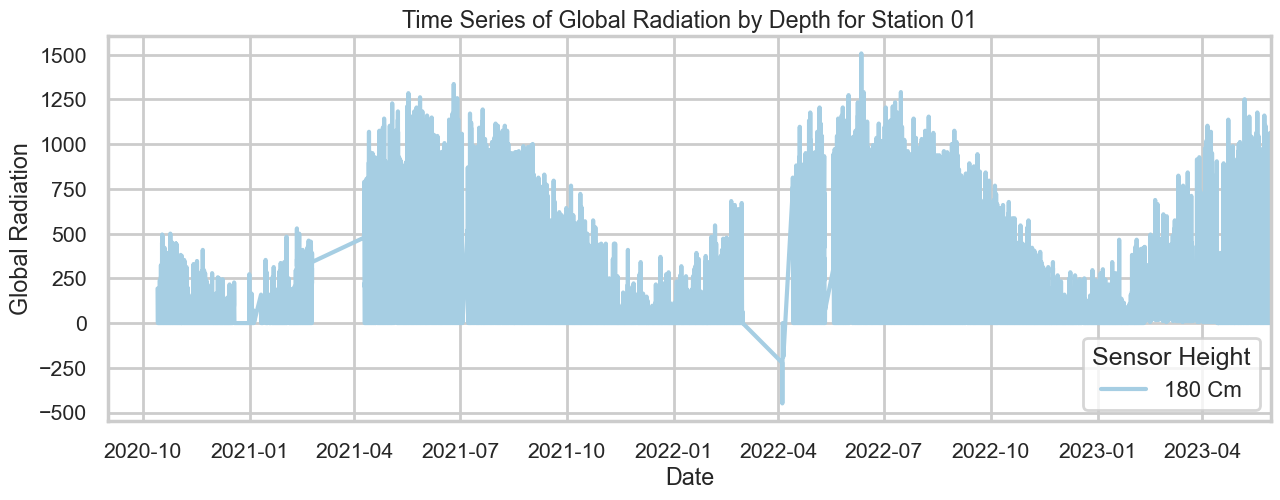

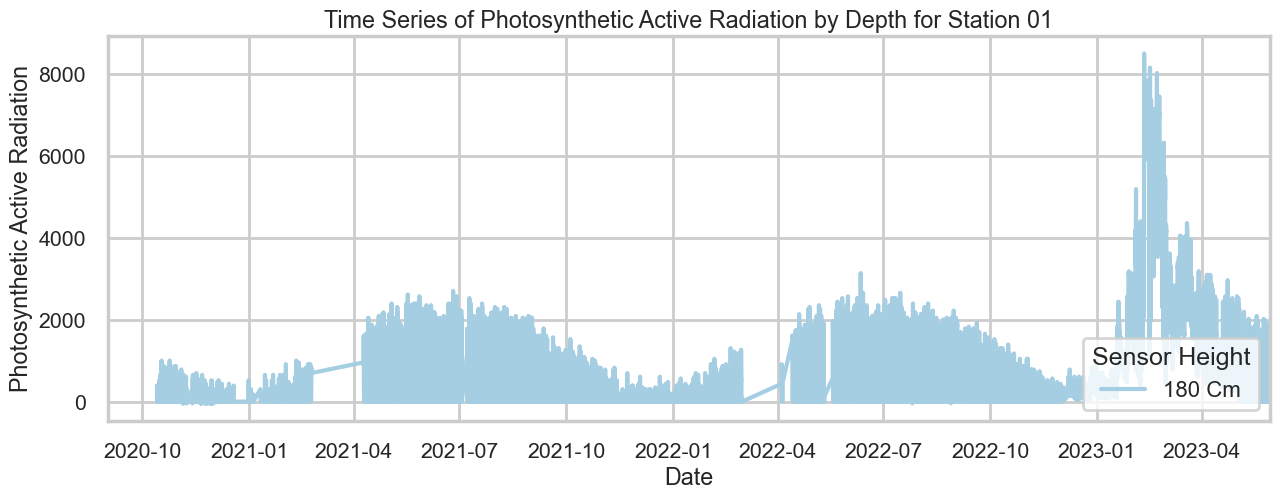

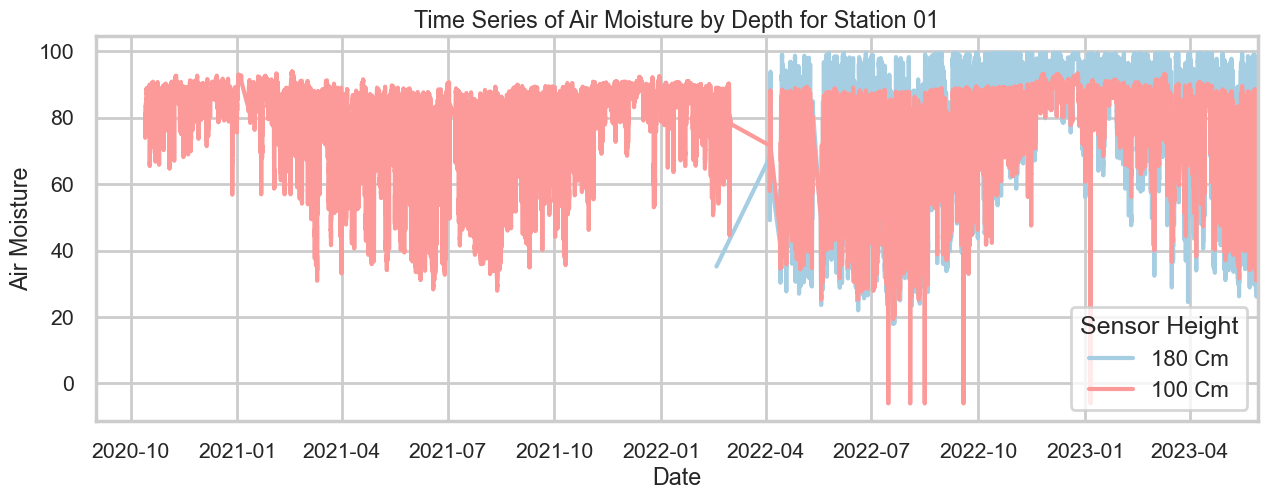

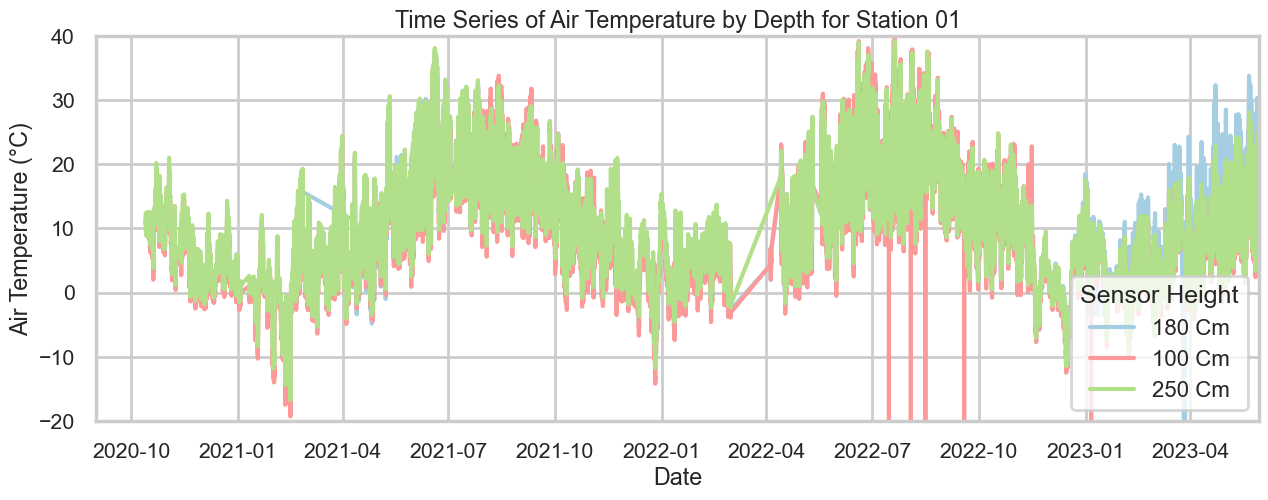

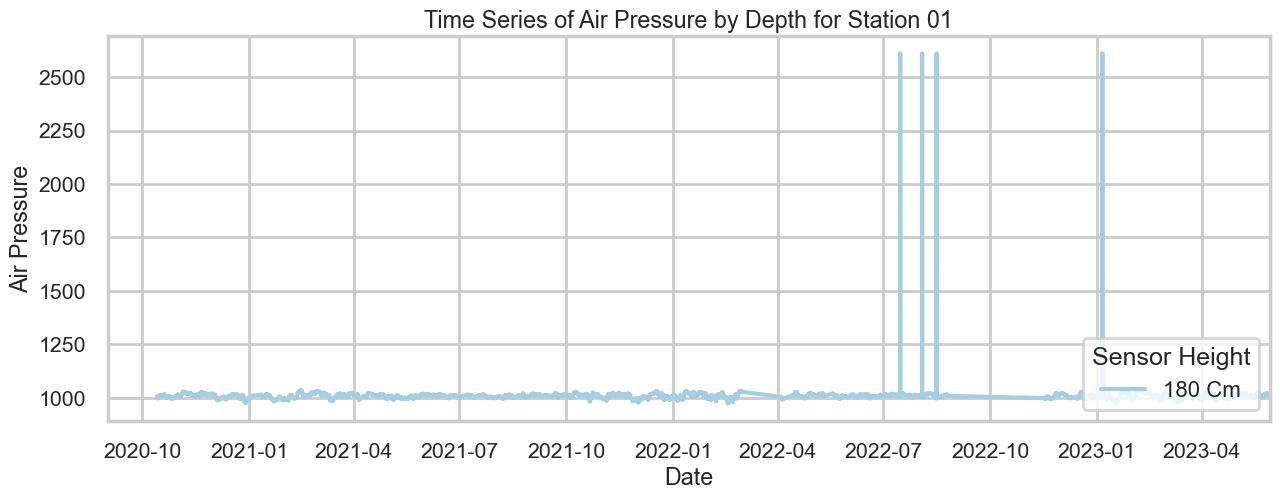

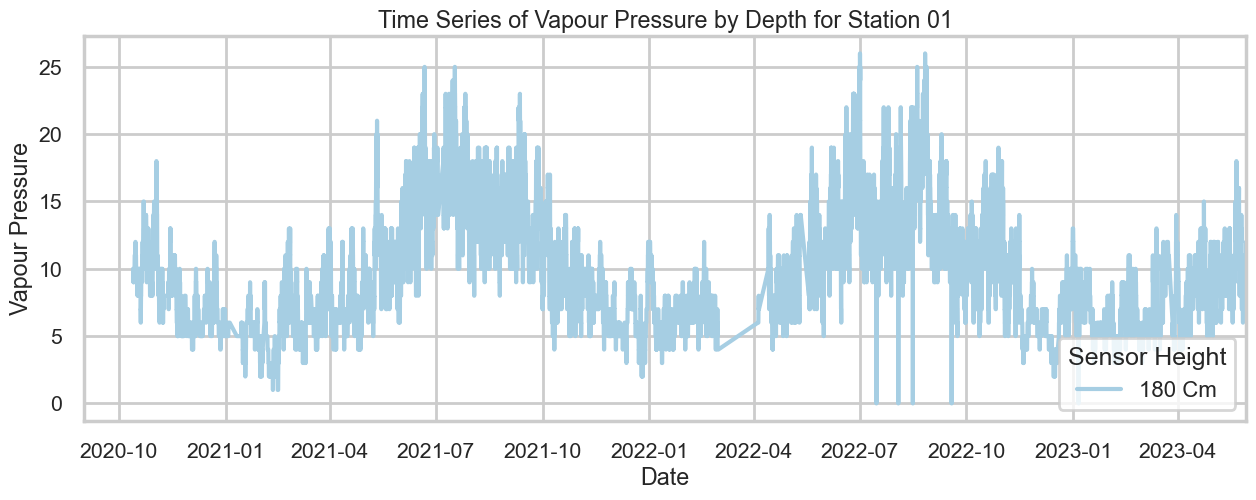

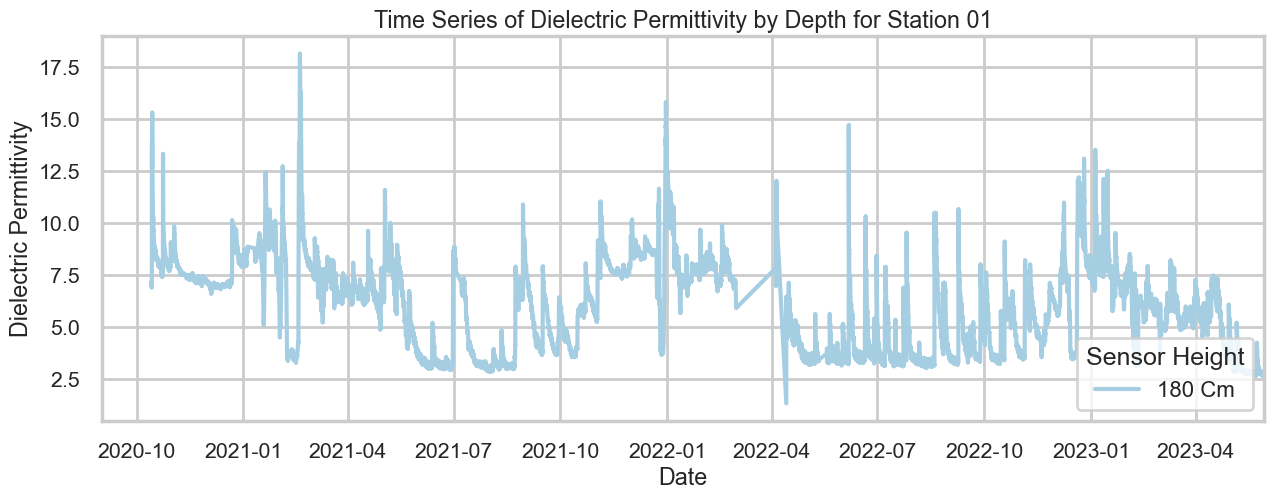

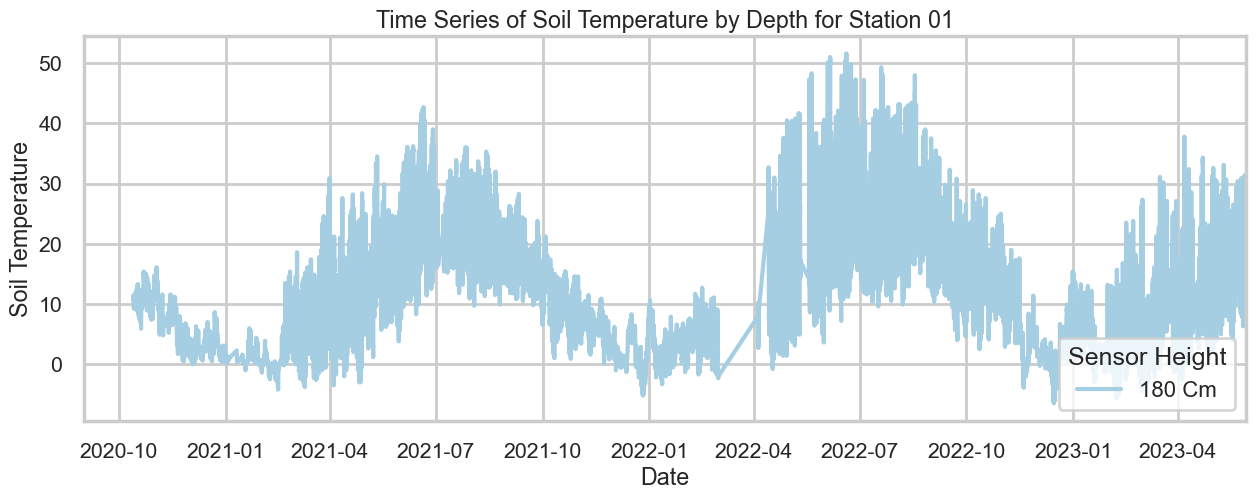

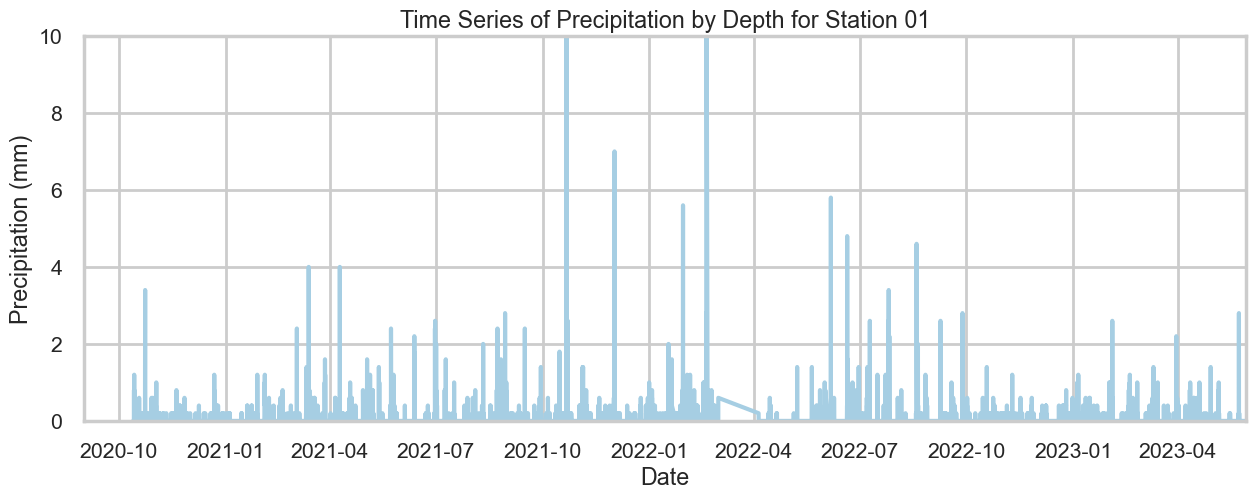

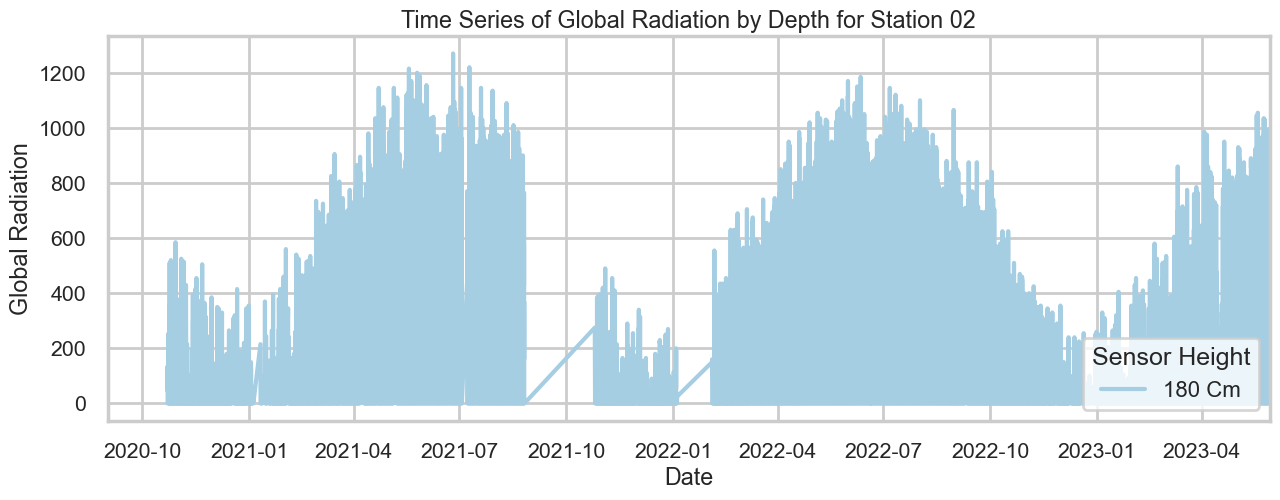

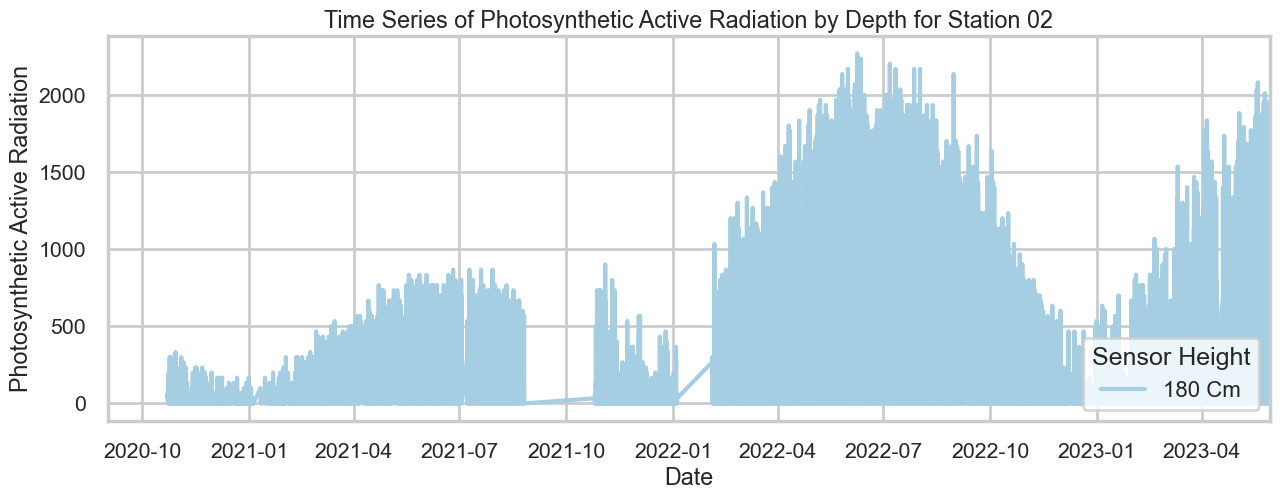

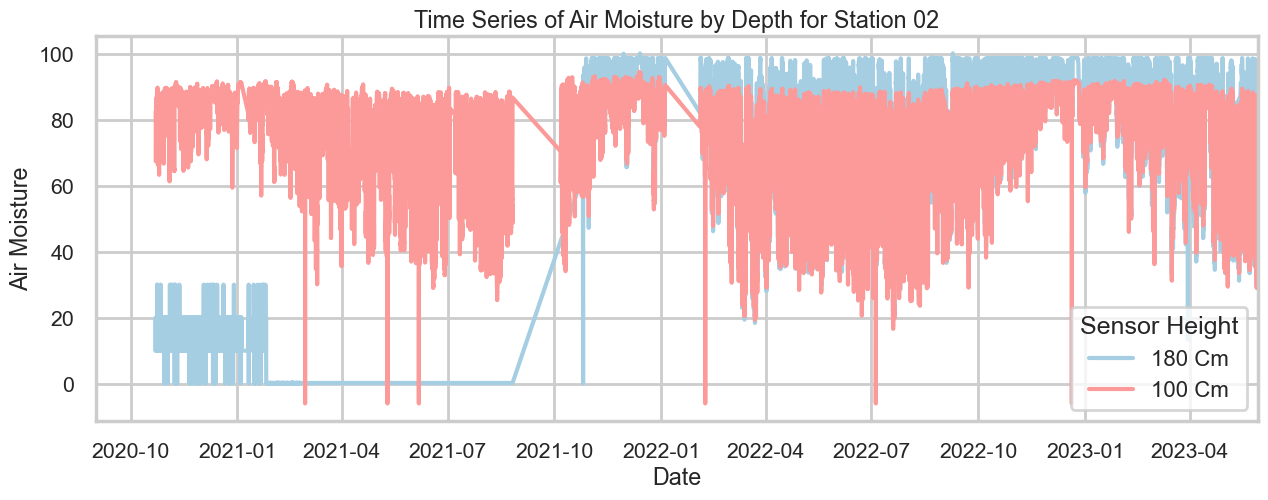

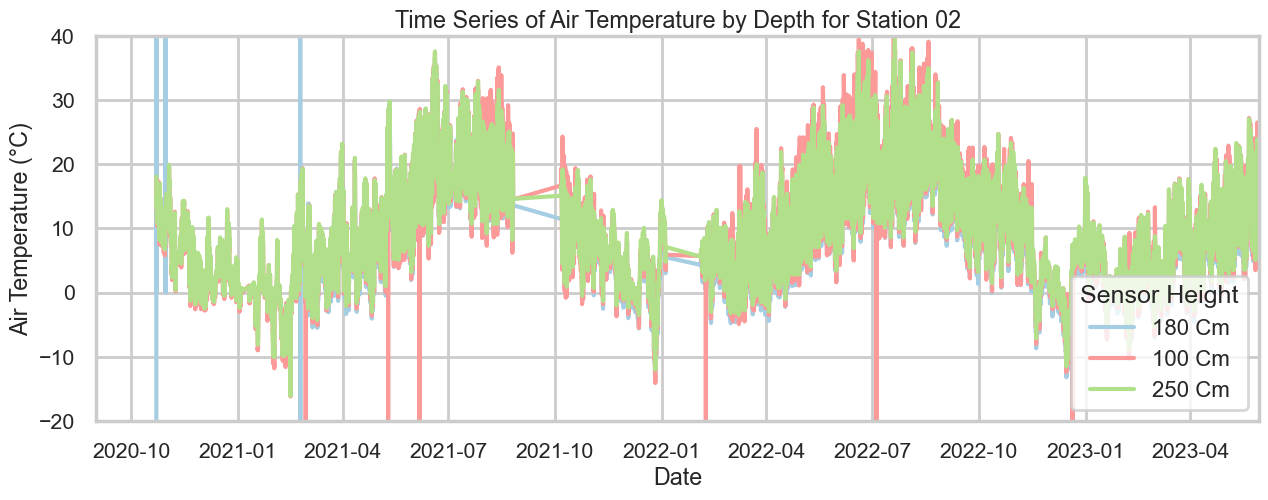

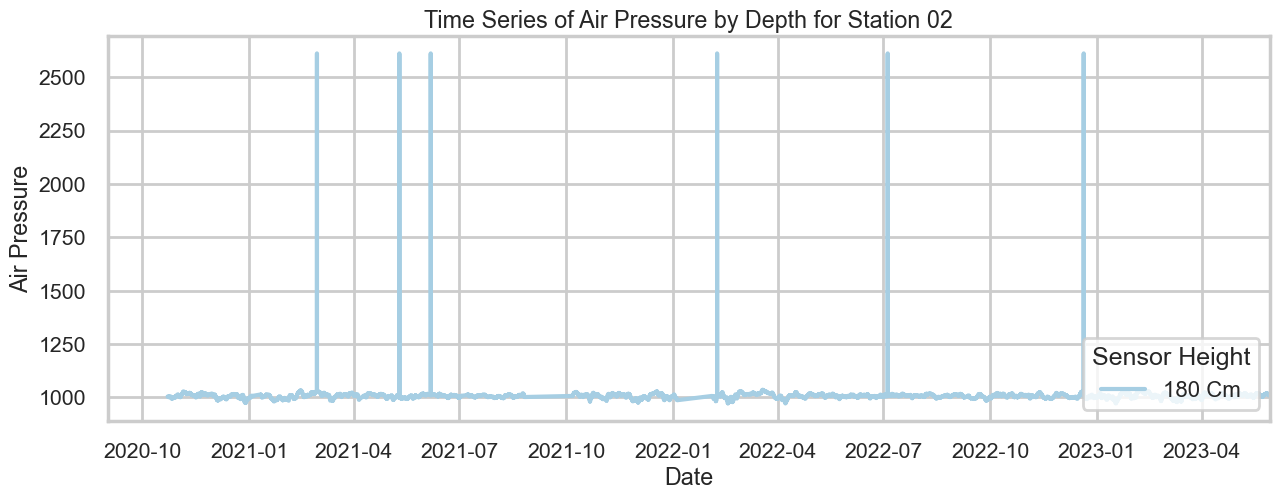

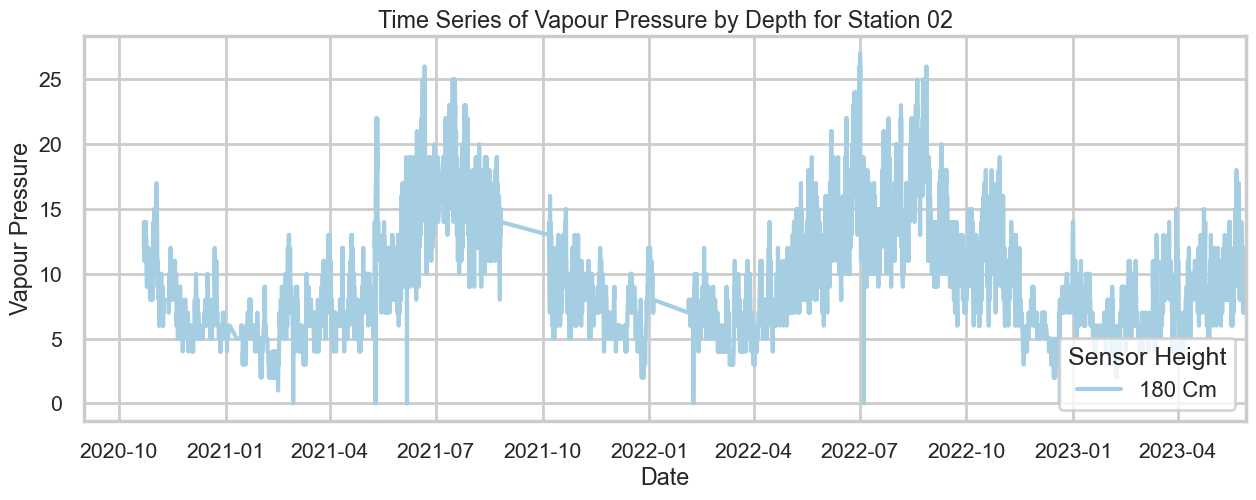

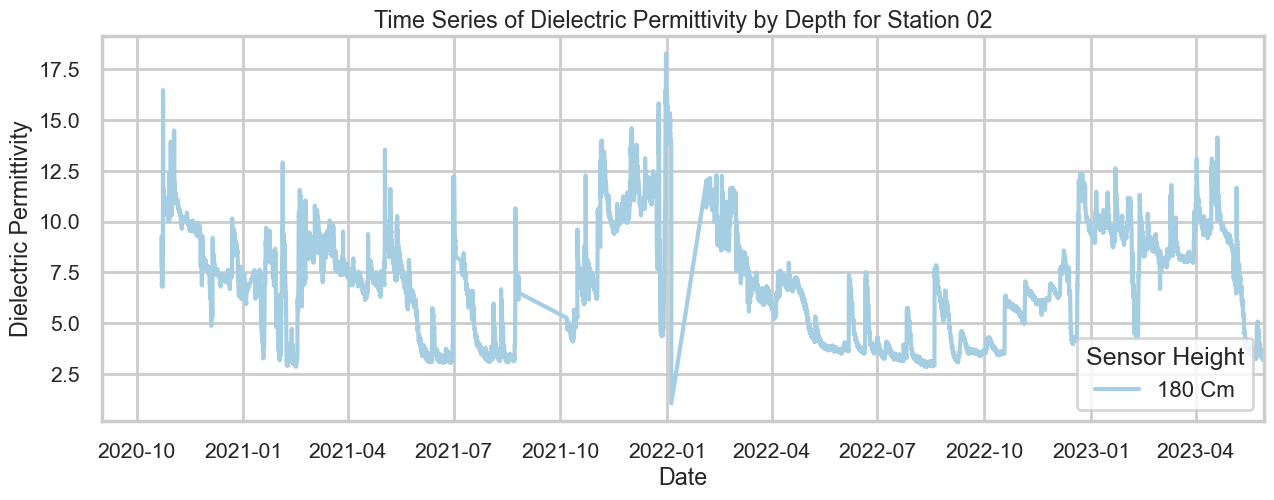

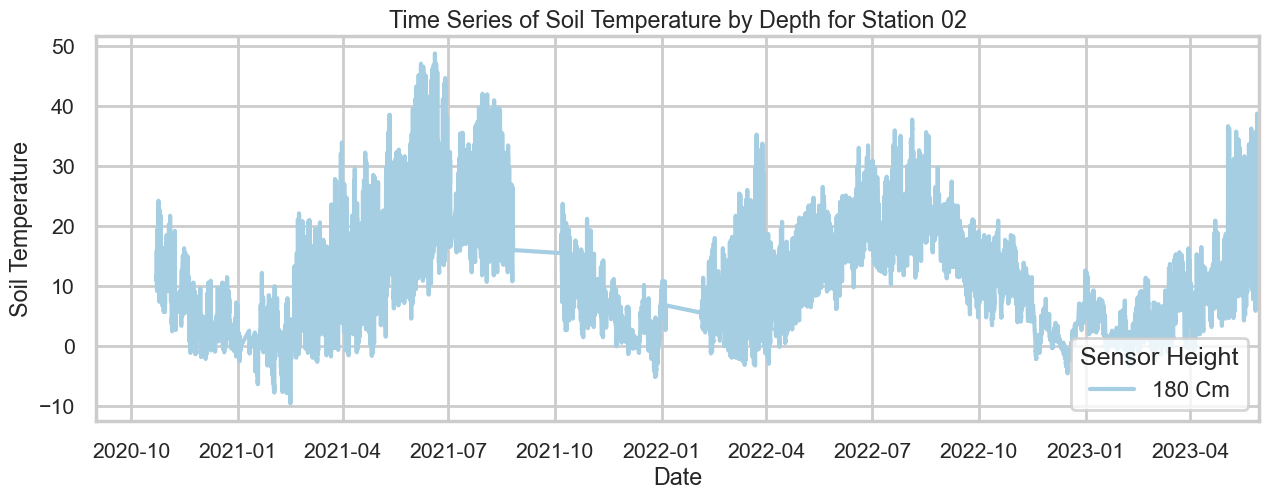

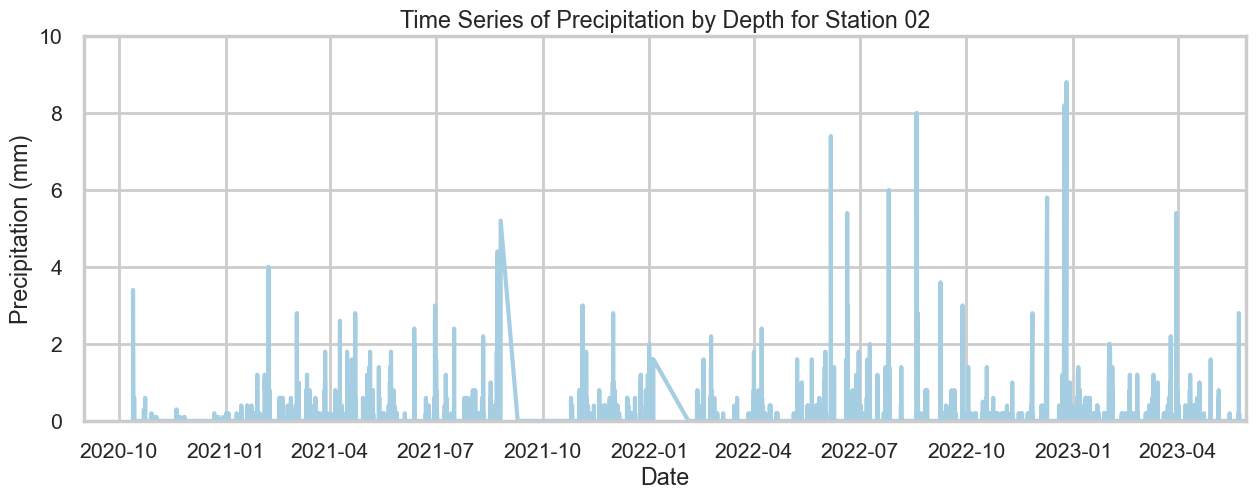

In [87]:
pattern = re.compile(r"(surface|air)_(100|180|250)_cm")

# Iterate over all CSV files in the directory
for filename in os.listdir(directory_path):
    if filename.startswith("weather"):
        # Load the data
        data = pd.read_csv(os.path.join(directory_path, filename), sep=',')
        station = filename.split("_")[2].split(".")[0]

        # Convert the 'datetime' column to a datetime object
        data['datetime'] = pd.to_datetime(data['dateTime'])

        # Set the 'datetime' column as the index
        data.set_index('datetime', inplace=True)
        
        # Group columns by their measurement type
        column_groups = {}
        for col in data.columns:
            if pattern.search(col):  # Only consider relevant columns
                measurement_type = extract_measurement_type(col)
                column_groups.setdefault(measurement_type, []).append(col)
            elif (col == 'precipitation'):
                measurement_type = 'precipitation'
                column_groups.setdefault(measurement_type, []).append(col)


        # For each measurement type, plot all relevant columns on a single graph
        for measurement_type, cols in column_groups.items():
            # Melt data into long format
            long_df = data[cols].reset_index().melt(id_vars=['datetime'], var_name='side_depth', value_name='value')
            
            # Extract and shorten the side_depth column using regex
            long_df['side_depth'] = long_df['side_depth'].apply(lambda x: pattern.search(x).group() if pattern.search(x) else x)

            # Format variables
            formatted_measurement_type = format_measurement_type(measurement_type)
            long_df['formatted_side_depth'] = long_df['side_depth'].apply(format_variable_type)
            
            #Plot
            plt.figure(figsize=(15, 5))
            sns.lineplot(data=long_df.dropna(), x='datetime', y='value', hue='formatted_side_depth')
            title = f'Time Series of {formatted_measurement_type} by Depth for Station {station}'
            plt.title(title)
            plt.xlabel('Date')
            plt.ylabel(formatted_measurement_type)
            plt.grid(True)
            plt.xlim(start_date, end_date)
            if measurement_type == 'precipitation':
                title = f'Time Series of {formatted_measurement_type} for Station {station}'
                plt.ylim(0,10)
                plt.ylabel((formatted_measurement_type + ' (mm)'))
                plt.gca().legend().set_visible(False)
            elif measurement_type == 'air_temperature_':
                plt.ylim(-20,40)
                plt.ylabel((formatted_measurement_type + ' (°C)'))
                plt.legend(title='Sensor Height', loc='lower right')
            else:
                plt.legend(title='Sensor Height', loc='lower right')
                
            
            # Save the plot
            plt.savefig(create_filename_from_title('weather', title),
                        dpi = 300,
                        bbox_inches = 'tight')
            
            # Show the plot
            plt.show()